In [1]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/idiosyncratic-neural-geometry/notebooks')
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

from abc import ABC, abstractmethod
import h5py
import numpy as np
from typing import Dict, List, Optional, Tuple, Any, Union
from pathlib import Path
from scipy import stats
from dataclasses import dataclass
from src.utils._config import *
from src.utils._io import *
from src.utils.plot import *
from src.utils.binning import *
from src.spectra._definition import *
from src.idm._definition import *
import argparse
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import os
HOME_DIR = Path("/data/chan21/idiosyncratic-neural-geometry/")

In [2]:
movies = ['iteration', 'defeat', 'growth', 'lemonade']
rois = ['occipital', 'ventral', 'temporal', 'dmn'] 
rois_names = {'occipital': 'early',
            'ventral': 'ventral',
            'temporal': 'lateral',
            'dmn': 'parietal-cingulate'} 
behavioral_isc = {roi: [] for roi in rois}
behavioral = {roi: [] for roi in rois}
behavioral_anat = {}
permuted_isc = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
permuted = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
permuted_anat = {}
significance_isc = {roi: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for roi in rois}
significance = {roi: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for roi in rois}
significance_movie_isc = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
significance_movie = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
significance_anat = {}

In [3]:
rank_slices = [(0, 10), (10, 100), (100, None)]
embs = pickle.load(open('/home/chan21/idiosyncratic-neural-geometry/results/embs.pkl', 'rb'))
def create_use_rdm(embs, movie):
    capitalized_movie = movie.capitalize()
    vector = embs[capitalized_movie]
    use_rdm = cosine_similarity(vector, vector)
    return use_rdm

def compute_idm(args, anat=False):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )

    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path
    print(h5_data_path)
    
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    if anat:
        corrs = {movie: [] for movie in movies}
        for movie in movies:
            x = get_upper_triangle(create_use_rdm(embs, movie))
            y = get_upper_triangle(anat_matrices[movie])
            corr = stats.spearmanr(x, y)[0]
            corrs[movie].append(corr)
        return corrs

    idm_series = {}
    corrs_series = {movie: {slice: [] for slice in rank_slices} for movie in movies}
    with h5py.File(h5_data_path, 'r') as h5f:
        # Initialize array to store all spectra    
        for movie in movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(rank_slices)))
            # Load spectra for each subject pair
            for i, i_subject in enumerate(subjects):
                for j, j_subject in enumerate(subjects[i+1:], i+1):
                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:]
        
                    for s, slices in enumerate(rank_slices):
                        all_spectra[i, j, s] = spectrum[slices[0]:slices[1]].mean() if slices[1] is not None else spectrum[slices[0]:].mean()
                        all_spectra[j, i, s] = all_spectra[i, j, s]
            idm_series[movie] = all_spectra            
    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    for m, movie in enumerate(movies):
        idm_series[movie] = np.moveaxis(idm_series[movie], -1, 0)
        rdm = create_use_rdm(embs, movie)
        y = get_upper_triangle(rdm) 
        if type(args.motion_type) == list:
            z1 = get_upper_triangle(motion_matrices[0][movie])
            z2 = get_upper_triangle(motion_matrices[1][movie])
            if args.isc:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    _, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs, _, _ = analysis._partial_correlation(rx, ry, get_upper_triangle(anat_matrices[movie]))
                    corrs_series[movie][slices].append(float(corrs))
            else:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    corrs, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs_series[movie][slices].append(float(corrs))
        else:
            if args.isc:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    corrs, _, _ = analysis._partial_correlation(rx, ry, get_upper_triangle(anat_matrices[movie]))
                    corrs_series[movie][slices].append(float(corrs))
            else:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    corrs, _, _ = analysis._partial_correlation(x, y, z1)
                    corrs_series[movie][slices].append(float(corrs))
    return corrs_series



2025-05-18 16:08:11.565558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 16:08:12.424648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-05-18 16:08:13.571945: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:

def permute_idm(args, n_permutations=10):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    permuted_series = {movie: [] for movie in movies}
    with h5py.File(h5_data_path, 'r') as h5f:
        for p in tqdm(range(n_permutations)):
            for movie in movies:
                all_spectra = np.zeros((n_subjects, n_subjects, len(rank_slices)))
                perm_i = np.random.permutation(subjects)
                perm_j = np.random.permutation(subjects)
                for i, i_subject in enumerate(perm_i):
                    for j, j_subject in enumerate(perm_j):
                        if i_subject != j_subject:
                            try:
                                spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:]
                            except:
                                spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:]
                            for s, slices in enumerate(rank_slices):
                                all_spectra[i, j, s] = spectrum[slices[0]:slices[1]].mean() if slices[1] is not None else spectrum[slices[0]:].mean()
                                all_spectra[j, i, s] = all_spectra[i, j, s]
                permuted_series[movie].append(np.moveaxis(all_spectra, -1, 0))
    
    perm_corrs = []

    for p in tqdm(range(n_permutations)):
        corrs_series = {movie: {slice: [] for slice in rank_slices} for movie in movies}
        for m, movie in enumerate(movies):
            z1 = get_upper_triangle(motion_matrices[0][movie])
            z2 = get_upper_triangle(motion_matrices[1][movie])
            y = get_upper_triangle(create_use_rdm(embs, movie))
            if args.isc:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(permuted_series[movie][p][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    _, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs, _, _ = analysis._partial_correlation(rx, ry, get_upper_triangle(anat_matrices[movie]))
                    corrs_series[movie][slices].append(corrs)
            else:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(permuted_series[movie][p][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    corrs, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs_series[movie][slices].append(float(corrs))
        perm_corrs.append(corrs_series)
    return perm_corrs


def permute_anat(args, n_permutations=10):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    rdms = {}
    for m, movie in enumerate(movies):
        rdm = create_use_rdm(embs, movie)
        rdms[movie] = rdm
    
    perm_corrs = {movie: [] for movie in movies}   
    for p in tqdm(range(n_permutations)):
        np.random.seed(p)
        permuted_series = {movie: np.zeros((n_subjects, n_subjects)) for movie in movies}
        for movie in movies:
            perm_i = np.random.permutation(subjects)
            perm_j = np.random.permutation(subjects)
            for i, i_subject in enumerate(perm_i):
                for j, j_subject in enumerate(perm_j):
                    if i_subject != j_subject:
                        permuted_series[movie][i, j] = anat_matrices[movie][config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        permuted_series[movie][j, i] = permuted_series[movie][i, j]
            x = get_upper_triangle(permuted_series[movie])
            y = get_upper_triangle(rdms[movie])
            z1 = get_upper_triangle(motion_matrices[0][movie])
            z2 = get_upper_triangle(motion_matrices[1][movie])
            if type(args.motion_type) == list:
                _, rx, ry = analysis._partial_correlation(x, y, z1)
                corrs, _, _ = analysis._partial_correlation(rx, ry, z2)
                perm_corrs[movie].append(float(corrs))
            else:
                corrs, _, _ = analysis._partial_correlation(x, y, z1)
                perm_corrs[movie].append(float(corrs))
    return perm_corrs

In [ ]:

for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/idiosyncratic-neural-geometry/results/",
        motion_type=["ISC", "AnnaK"],
        isc=True,
        isc_dir=f"/data/chan21/idiosyncratic-neural-geometry/results/isc_{roi}_functional/eigenspectra.h5", 
        anatomical=False,
    )
    corrs = compute_idm(args)
    behavioral_isc[roi] = corrs
    perm_corrs = permute_idm(args, n_permutations=1000)
    
    perm_movie = np.array([[[eigen[0] for eigen in eigen_data.values()] for eigen_data in perm_corr.values()] for perm_corr in perm_corrs]) # (n_permutations, 4, 3)
    perm_movie_mean = np.mean(perm_movie, axis=1)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        permuted = perm_movie_mean[:, i]
        observed = np.mean([[movie_data[eigen][0] for eigen in movie_data.keys()] for movie_data in behavioral_isc[roi].values()], axis=0)
        p = np.sum(np.array(permuted) > observed[i]) / len(permuted)
        significance_isc[roi][slices] = p

        for n_mov, movie in enumerate(behavioral_isc[roi].keys()):
            permuted = perm_movie[:, n_mov, i]
            observed = [eigen for eigen in behavioral_isc[roi][movie][slices]]
            p = np.sum(np.array(permuted) > observed) / len(permuted)
            significance_movie_isc[roi][movie][slices] = p

    corrs = compute_idm(args, anat=True)
    behavioral_anat[roi] = corrs
    
    perm_corrs = permute_anat(args, n_permutations=1000)
    permuted = np.mean([perm_corrs[movie] for movie in movies], axis=0)
    observed = np.mean([behavioral_anat[roi][movie] for movie in movies], axis=0)
    p = np.sum(np.array(permuted) > observed) / len(permuted)
    significance_anat[roi] = p

    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=False,
        isc_dir=f"/data/chan21/idiosyncratic-neural-geometry/results/isc_{roi}_functional/eigenspectra.h5", 
        anatomical=False,
    )

    corrs = compute_idm(args)
    print(f"behavioral[{roi}]: {corrs}")
    behavioral[roi] = corrs

    perm_corrs = permute_idm(args, n_permutations=1000)
    
    perm_movie = np.array([[[eigen[0] for eigen in eigen_data.values()] for eigen_data in perm_corr.values()] for perm_corr in perm_corrs]) # (n_permutations, 4, 3)
    perm_movie_mean = np.mean(perm_movie, axis=1)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        permuted = perm_movie_mean[:, i]
        observed = np.mean([[movie_data[eigen][0] for eigen in movie_data.keys()] for movie_data in behavioral[roi].values()], axis=0)
        p = np.sum(np.array(permuted) > observed[i]) / len(permuted)
        significance[roi][slices] = p

        for n_mov, movie in enumerate(behavioral[roi].keys()):
            permuted = perm_movie[:, n_mov, i]
            observed = [eigen for eigen in behavioral[roi][movie][slices]]
            p = np.sum(np.array(permuted) > observed) / len(permuted)
            significance_movie[roi][movie][slices] = p

In [7]:
from statsmodels.stats.multitest import fdrcorrection

for roi in rois:
    p_values = [significance_isc[roi][slices] for slices in [(0, 10), (10, 100), (100, None)]]
    significant, corrected_p_values = fdrcorrection(p_values, alpha=0.05)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        significance_isc[roi][slices] = corrected_p_values[i]
    p_values = [significance[roi][slices] for slices in [(0, 10), (10, 100), (100, None)]]
    significant, corrected_p_values = fdrcorrection(p_values, alpha=0.05)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        significance[roi][slices] = corrected_p_values[i]

    p_values = significance_anat[roi]
    significant, corrected_p_values = fdrcorrection([p_values], alpha=0.05)
    significance_anat[roi] = corrected_p_values[0]

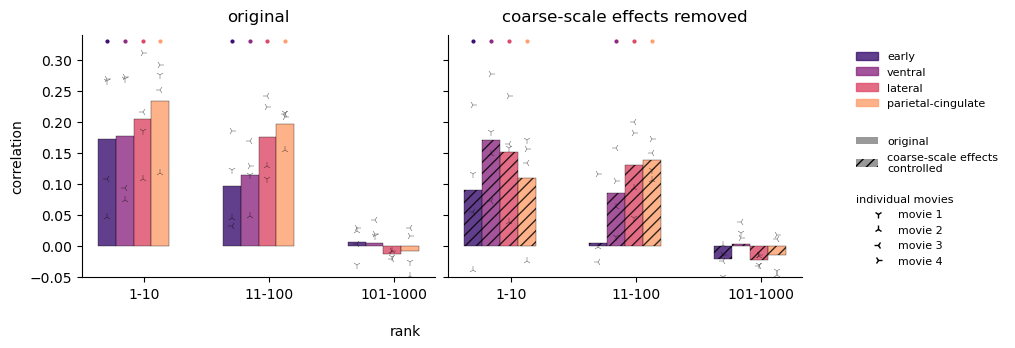

In [17]:
from matplotlib.patches import Rectangle
idm_roi_colors = sns.color_palette("magma", len(rois))
markers = ['1', '2', '3', '4']
movies = ['iteration', 'defeat', 'growth', 'lemonade'] 

def create_nature_figures():
    plt.rcParams.update({'figure.figsize': (8, 3)})
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    bar_width = 0.05  
    decade_spacing = 0.35  
    roi_spacing = 0.05  
    line_length = bar_width * 1
    
    def plot_condition(ax, data, significance_data, pattern):
        for d, eigen in enumerate(rank_slices):
            x_base = d * decade_spacing
            for r, roi in enumerate(rois):
                x_pos = x_base + (r * roi_spacing)
                mean_val = np.mean([data[roi][movie][eigen] for movie in movies])
                
                bar = ax.bar(x_pos, mean_val,
                           width=bar_width, color=idm_roi_colors[r],
                           alpha=0.8, edgecolor='black', linewidth=0.3)[0]
                
                if pattern:
                    bar.set_hatch('///')
                
                true_center = bar.get_x() + (bar.get_width() / 2)
                
                for n_mov, movie in enumerate(movies):
                    ax.plot(true_center, data[roi][movie][eigen],
                           marker=markers[n_mov], color=idm_roi_colors[r],
                           alpha=0.8, markersize=6,
                           markeredgecolor='black', markeredgewidth=0.3,
                           zorder=3)
                
                if significance_data[roi][eigen] < 0.05:
                    ax.plot(true_center, 0.33,  
                        marker='o', 
                        color=idm_roi_colors[r], 
                        markersize=2, 
                        zorder=4)
    
    plot_condition(ax1, behavioral, significance, False)
    ax1.set_title('original', pad=10)
    plot_condition(ax2, behavioral_isc, significance_isc, True)
    ax2.set_title('coarse-scale effects removed', pad=10)
    
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-0.05, 0.34)
        ax.set_xticks([0.105, 0.455, 0.805])
        ax.set_xticklabels(['1-10', '11-100', '101-1000'])
    
    ax1.set_ylabel("correlation")
    ax2.set_yticklabels([])
    
    roi_patches = [Rectangle((0,0), 1, 1, color=idm_roi_colors[i], alpha=0.8) 
                  for i in range(len(rois))]
    
    pattern_patches = [
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, label='$\mathrm{IDM_{PLS}}$'),
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, hatch='///', label='$\mathrm{IDM_{PLS|ISC}}$')
    ]
    
    movie_markers = [plt.Line2D([0], [0], marker=markers[i], color='black', 
                             linestyle='', markersize=6) 
                    for i in range(len(movies))]
    
    fig.legend(roi_patches, ['early', 'ventral', 'lateral', 'parietal-cingulate'],  
              bbox_to_anchor=(1.05, 0.75),
              loc='center left', 
              frameon=False, 
              fontsize=8)
    
    fig.legend(pattern_patches, ['original', 'coarse-scale effects \ncontrolled'],
              bbox_to_anchor=(1.05, 0.5),
              loc='center left',
              frameon=False,
              fontsize=8)
    
    fig.legend(movie_markers, ["movie 1", "movie 2", "movie 3", "movie 4"],
              bbox_to_anchor=(1.05, 0.25),
              loc='center left',
              frameon=False,
              fontsize=8,
              title="individual movies",
              title_fontsize=8)
    
    fig.text(0.5, -0.1, 'rank', ha='center')
    
    plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure4.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure4.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

create_nature_figures()